In [ ]:
import os
import pandas as pd
import numpy as np
import spacy
import pickle

import torch
import torch.nn as nn
import torch.nn.functional as F

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [ ]:
BASE_PATH = '/content/drive/MyDrive/Projects/Cryptofuture'

bitcoin_tweets_path = os.path.join(BASE_PATH, 'Finding Correlation/final_bitcoin_tweets.csv')
price_lags_path = os.path.join(BASE_PATH, 'Finding Correlation/price_lags.csv')

vocab_path = os.path.join(BASE_PATH, 'Sentiment Analysis/vocab.pickle')
sentiment_model_path = os.path.join(BASE_PATH, 'Sentiment Analysis/cnn_model.pt')


print(bitcoin_tweets_path)
print(price_lags_path)
print(vocab_path)
print(sentiment_model_path)

/content/drive/MyDrive/Projects/Cryptofuture/Finding Correlation/final_bitcoin_tweets.csv
/content/drive/MyDrive/Projects/Cryptofuture/Finding Correlation/price_lags.csv
/content/drive/MyDrive/Projects/Cryptofuture/Sentiment Analysis/vocab.pickle
/content/drive/MyDrive/Projects/Cryptofuture/Sentiment Analysis/cnn_model.pt


In [ ]:
tweets_df = pd.read_csv(bitcoin_tweets_path)

tweets_df

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (9) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,id,conversation_id,created_at,date,time,timezone,user_id,username,name,place,tweet,language,mentions,urls,photos,replies_count,retweets_count,likes_count,hashtags,cashtags,link,retweet,quote_url,video,thumbnail,near,geo,source,user_rt_id,user_rt,retweet_id,reply_to,retweet_date,translate,trans_src,trans_dest
0,1373202105586966528,1373202105586966528,2021-03-20 14:47:49 IST,2021-03-20,14:47:49,530,904700529988820992,mmcrypto,MMCrypto,NaN,#BITCOIN BREAKOUT IMMINENT WITHIN THE NEXT 8 H...,en,[],[],[],49,38,1324,['bitcoin'],[],https://twitter.com/MMCrypto/status/1373202105...,False,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN
1,1373199295239819268,1373199295239819268,2021-03-20 14:36:39 IST,2021-03-20,14:36:39,530,978732571738755072,themooncarl,The Moon 🌙,NaN,You should try to buy as much #Bitcoin as you ...,en,[],[],[],43,36,444,['bitcoin'],[],https://twitter.com/TheMoonCarl/status/1373199...,False,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN
2,1373198598322712584,1373198598322712584,2021-03-20 14:33:53 IST,2021-03-20,14:33:53,530,2469446510,cryptkeeperbtt,CryptKeeper,NaN,"👆Good job, new followers! Current #Bitcoin do...",en,"[{'screen_name': 'signalapp', 'name': 'signal'...",[],['https://pbs.twimg.com/media/Ew6U2JmWEAEFIB5....,4,6,24,"['bitcoin', 'stackingsats', 'giveaway']",[],https://twitter.com/CryptKeeperBTT/status/1373...,False,NaN,1,https://pbs.twimg.com/media/Ew6U2JmWEAEFIB5.jpg,NaN,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN
3,1373197337032544259,1373197337032544259,2021-03-20 14:28:52 IST,2021-03-20,14:28:52,530,1245908008934223874,gemhuntersyoyo,Mr. Yoyo ®️™,NaN,Christine Lagarde #ECB $Bitcoin is a funny bus...,en,[],[],[],2,5,14,['ecb'],[],https://twitter.com/GemHuntersYoyo/status/1373...,False,NaN,1,https://pbs.twimg.com/ext_tw_video_thumb/13731...,NaN,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN
4,1373195777980428288,1373195777980428288,2021-03-20 14:22:40 IST,2021-03-20,14:22:40,530,18469669,saifedean,Saifedean.com,NaN,Bitcoin's projected stock-to-flow ratio by yea...,en,[],[],['https://pbs.twimg.com/media/Ew6SJ9TXIAQZT3Y....,17,18,176,[],[],https://twitter.com/saifedean/status/137319577...,False,NaN,1,https://pbs.twimg.com/media/Ew6SJ9TXIAQZT3Y.png,NaN,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
328347,815444745010880512,815444745010880512,2017-01-01 11:59:12 India Standard Time,2017-01-01,11:59:12,530,13418472,woonomic,Willy Woo,NaN,2017 will be the year #bitcoin shakes its 2 ye...,en,[],['https://twitter.com/dangermouse117/status/79...,[],3,31,35,['bitcoin'],[],https://twitter.com/woonomic/status/8154447450...,False,https://twitter.com/dangermouse117/status/7933...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN
328348,815404137634467840,815404137634467840,2017-01-01 09:17:50 India Standard Time,2017-01-01,09:17:50,530,2375721396,satoshi_n_,Satoshi Nakamoto,NaN,2016 was a year of vindication for the value o...,en,[],[],[],5,20,45,[],[],https://twitter.com/Satoshi_N_/status/81540413...,False,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN
328349,815395665543069696,815395665543069696,2017-01-01 08:44:10 India Standard Time,2017-01-01,08:44:10,530,169914086,jacktatar,Jack Tatar,NaN,Not Just Bitcoin: The Top 7 Cryptocurrencies A...,en,"[{'screen_name': 'coindesk', 'name': 'coindesk...",['http://bit.ly/2iQHT1e'],[],0,9,13,[],[],https://twitter.com/JackTatar/status/815395665...,False,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN
328350,815349931376541696,815348087422062596,2017-01-01 05:42:26 India Standard Time,2017-01-01,05:42:26,530,295049967,mrchrisellis,Chris Ellis,NaN,This guy &gt;&gt; @MrHodl has the best trading...,en,"[{'screen_name': 'mrhodl', 'name': 'steve hodl...",[],['https://pbs.twimg.com/media/C1C0aulXEAEvFP5....,3,19,50,[],[],https://twitter.com/MrChrisEllis/status/815349...,False,NaN,1,https://pbs.twimg.com/media/C1C0aulXEAEvFP5.jpg,NaN,NaN,

In [ ]:
tweets_df_dropped = tweets_df[['date', 'tweet', 'likes_count', 'retweets_count']]

tweets_df_dropped

,date,tweet,likes_count,retweets_count
0,2021-03-20,#BITCOIN BREAKOUT IMMINENT WITHIN THE NEXT 8 H...,1324,38
1,2021-03-20,You should try to buy as much #Bitcoin as you ...,444,36
2,2021-03-20,"👆Good job, new followers! Current #Bitcoin do...",24,6
3,2021-03-20,Christine Lagarde #ECB $Bitcoin is a funny bus...,14,5
4,2021-03-20,Bitcoin's projected stock-to-flow ratio by yea...,176,18
...,...,...,...,...
328347,2017-01-01,2017 will be the year #bitcoin shakes its 2 ye...,35,31
328348,2017-01-01,2016 was a year of vindication for the value o...,45,20
328349,2017-01-01,Not Just Bitcoin: The Top 7 Cryptocurrencies A...,13,9
328350,2017-01-01,This guy &gt;&gt; @MrHodl has the best trading...,50,19


In [ ]:
with open(vocab_path, "rb") as f:
    text = pickle.load(f)

nlp = spacy.load("en_core_web_sm")


def positive_sentiment(model, tweet, min_length=10):
    model.eval()
    tokenized = [tok.text for tok in nlp.tokenizer(tweet)]
    if len(tokenized) < min_length:
        tokenized += ["<pad>"] * (min_length - len(tokenized))
    indexed = [text[t] for t in tokenized]
    tensor = torch.LongTensor(indexed).to(device)
    tensor = tensor.unsqueeze(0)
    prediction = torch.softmax(model(tensor, len(tensor)), dim=1)
    prediction = torch.squeeze(prediction)
    return prediction[1].item()


def negative_sentiment(model, tweet, min_length=10):
    model.eval()
    tokenized = [tok.text for tok in nlp.tokenizer(tweet)]
    if len(tokenized) < min_length:
        tokenized += ["<pad>"] * (min_length - len(tokenized))
    indexed = [text[t] for t in tokenized]
    tensor = torch.LongTensor(indexed).to(device)
    tensor = tensor.unsqueeze(0)
    prediction = torch.softmax(model(tensor, len(tensor)), dim=1)
    prediction = torch.squeeze(prediction)
    return prediction[0].item()


class CnnModel(nn.Module):
    def __init__(
        self, vocab_size, embed_size, num_filters, filter_sizes, output_classes, dropout
    ):
        super().__init__()
        self.vocab_size = vocab_size
        self.embed_size = embed_size
        self.num_filters = num_filters
        self.filter_sizes = filter_sizes
        self.output_classes = output_classes
        self.dropout = dropout

        self.embedding = nn.Embedding(self.vocab_size, self.embed_size)
        self.convs = nn.ModuleList(
            [
                nn.Conv2d(
                    in_channels=1,
                    out_channels=self.num_filters,
                    kernel_size=(fs, self.embed_size),
                )
                for fs in self.filter_sizes
            ]
        )
        self.fc = nn.Linear(
            len(self.filter_sizes) * self.num_filters, self.output_classes
        )
        self.dropout = nn.Dropout(self.dropout)

    def forward(self, text, text_lengths):
        embedded = self.embedding(text)
        embedded = embedded.unsqueeze(1)

        conved = [F.relu(conv(embedded)).squeeze(3) for conv in self.convs]
        pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]

        cat = self.dropout(torch.cat(pooled, dim=1))
        return self.fc(cat)


model = CnnModel(
    vocab_size=6002,
    embed_size=100,
    num_filters=100,
    filter_sizes=[3, 4, 5],
    output_classes=2,
    dropout=0.8,
)

model.load_state_dict(torch.load(sentiment_model_path, map_location=device))

<All keys matched successfully>

In [ ]:
model = model.to(device)

In [ ]:
positive_sentiment(model, "Bad"), negative_sentiment(model, "Bad")

(0.014541728422045708, 0.985458254814148)

In [8]:
tweets_df_dropped["pos_sentiment"] = tweets_df_dropped.tweet.apply(lambda x: positive_sentiment(model, x))
tweets_df_dropped["neg_sentiment"] = tweets_df_dropped.tweet.apply(lambda x: negative_sentiment(model, x))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [9]:
tweets_df_dropped

,date,tweet,likes_count,retweets_count,pos_sentiment,neg_sentiment
0,2021-03-20,#BITCOIN BREAKOUT IMMINENT WITHIN THE NEXT 8 H...,1324,38,0.653068,0.346932
1,2021-03-20,You should try to buy as much #Bitcoin as you ...,444,36,0.914574,0.085426
2,2021-03-20,"👆Good job, new followers! Current #Bitcoin do...",24,6,0.922262,0.077738
3,2021-03-20,Christine Lagarde #ECB $Bitcoin is a funny bus...,14,5,0.976097,0.023903
4,2021-03-20,Bitcoin's projected stock-to-flow ratio by yea...,176,18,0.599179,0.400821
...,...,...,...,...,...,...
328347,2017-01-01,2017 will be the year #bitcoin shakes its 2 ye...,35,31,0.630030,0.369970
328348,2017-01-01,2016 was a year of vindication for the value o...,45,20,0.886371,0.113629
328349,2017-01-01,Not Just Bitcoin: The Top 7 Cryptocurrencies A...,13,9,0.286016,0.713984
328350,2017-01-01,This guy &gt;&gt; @MrHodl has the best trading...,50,19,0.812497,0.187503


In [10]:
tweets_df_dropped = tweets_df_dropped[abs(tweets_df_dropped['pos_sentiment'] - tweets_df_dropped['neg_sentiment']) > 0.1]

tweets_df_dropped

,date,tweet,likes_count,retweets_count,pos_sentiment,neg_sentiment
0,2021-03-20,#BITCOIN BREAKOUT IMMINENT WITHIN THE NEXT 8 H...,1324,38,0.653068,0.346932
1,2021-03-20,You should try to buy as much #Bitcoin as you ...,444,36,0.914574,0.085426
2,2021-03-20,"👆Good job, new followers! Current #Bitcoin do...",24,6,0.922262,0.077738
3,2021-03-20,Christine Lagarde #ECB $Bitcoin is a funny bus...,14,5,0.976097,0.023903
4,2021-03-20,Bitcoin's projected stock-to-flow ratio by yea...,176,18,0.599179,0.400821
...,...,...,...,...,...,...
328347,2017-01-01,2017 will be the year #bitcoin shakes its 2 ye...,35,31,0.630030,0.369970
328348,2017-01-01,2016 was a year of vindication for the value o...,45,20,0.886371,0.113629
328349,2017-01-01,Not Just Bitcoin: The Top 7 Cryptocurrencies A...,13,9,0.286016,0.713984
328350,2017-01-01,This guy &gt;&gt; @MrHodl has the best trading...,50,19,0.812497,0.187503


In [19]:
gp = tweets_df_dropped.groupby(tweets_df_dropped.date)

len(gp), len(tweets_df_dropped.date.unique())

(1540, 1540)

In [20]:
final = []

column_names = [
                'date', 'pos_likes_count', 'neg_likes_count', 'pos_retweets_count', 
                'neg_retweets_count', 'sum_pos_sen', 
                'sum_neg_sen', 'mean_pos_sen', 'mean_neg_sen',
                'median_pos_sen', 'median_neg_sen', 'std_pos_sen', 'std_neg_sen',
                'skew_pos_sen', 'skew_neg_sen', 'kurtosis_pos_sen', 'kurtosis_neg_sen',
                'tweet_vol'
]

for date in tweets_df_dropped.date.unique()[::-1]:

    gp_df = gp.get_group(date)

    pos_gp_df = gp_df[gp_df['pos_sentiment'] > gp_df['neg_sentiment']]
    neg_gp_df = gp_df[gp_df['neg_sentiment'] > gp_df['pos_sentiment']]

    date = date

    pos_likes_count = pos_gp_df.likes_count.sum()
    neg_likes_count = neg_gp_df.likes_count.sum()

    pos_retweets_count = pos_gp_df.retweets_count.sum()
    neg_retweets_count = neg_gp_df.retweets_count.sum()

    sum_pos_sen = pos_gp_df.pos_sentiment.sum()
    sum_neg_sen = neg_gp_df.neg_sentiment.sum()

    mean_pos_sen = pos_gp_df.pos_sentiment.mean()
    mean_neg_sen = neg_gp_df.neg_sentiment.mean()

    median_pos_sen = pos_gp_df.pos_sentiment.median()
    median_neg_sen = neg_gp_df.neg_sentiment.median()

    std_pos_sen = pos_gp_df.pos_sentiment.std()
    std_neg_sen = neg_gp_df.neg_sentiment.std()

    skew_pos_sen = pos_gp_df.pos_sentiment.skew()
    skew_neg_sen = neg_gp_df.neg_sentiment.skew()

    kurtosis_pos_sen = pos_gp_df.pos_sentiment.kurtosis()
    kurtosis_neg_sen = neg_gp_df.neg_sentiment.kurtosis()

    tweet_vol = len(gp_df)

    final.append([
                  date, pos_likes_count, neg_likes_count, pos_retweets_count, 
                  neg_retweets_count, sum_pos_sen,
                  sum_neg_sen, mean_pos_sen, mean_neg_sen,
                  median_pos_sen, median_neg_sen, std_pos_sen, std_neg_sen,
                  skew_pos_sen, skew_neg_sen, kurtosis_pos_sen, kurtosis_neg_sen,
                  tweet_vol])

In [21]:
df = pd.DataFrame(final, columns=column_names)

df

,date,pos_likes_count,neg_likes_count,pos_retweets_count,neg_retweets_count,sum_pos_sen,sum_neg_sen,mean_pos_sen,mean_neg_sen,median_pos_sen,median_neg_sen,std_pos_sen,std_neg_sen,skew_pos_sen,skew_neg_sen,kurtosis_pos_sen,kurtosis_neg_sen,tweet_vol
0,2017-01-01,884,333,580,162,11.441429,6.160855,0.817245,0.770107,0.864431,0.747215,0.122269,0.107939,-1.071271,0.806148,-0.094580,0.148902,22
1,2017-01-02,5335,1444,3631,620,41.188336,9.886617,0.762747,0.706187,0.790568,0.698603,0.129751,0.114417,-0.118365,1.120719,-1.211109,0.985415,68
2,2017-01-03,2104,436,1405,258,23.866358,6.229506,0.723223,0.692167,0.710602,0.635604,0.112787,0.126986,0.425864,1.087090,-0.585921,0.354295,42
3,2017-01-04,3702,1152,2586,812,36.724756,14.832695,0.749485,0.706319,0.758723,0.708842,0.107360,0.090134,0.080198,0.001365,-0.947776,-1.399742,70
4,2017-01-05,3372,2654,2737,1810,46.652301,24.570946,0.740513,0.722675,0.758723,0.716897,0.106673,0.122467,0.030672,0.495685,-0.919614,-0.519497,97
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1535,2021-03-16,295276,89563,86015,10754,529.647798,182.759931,0.776610,0.728127,0.773050,0.712893,0.120452,0.121245,-0.095265,0.373023,-1.111080,-0.957717,933
1536,2021-03-17,348023,85903,109632,12304,559.261733,173.410921,0.780002,0.710700,0.790987,0.695352,0.120255,0.112463,-0.166074,0.476931,-1.100739,-0.893673,961
1537,2021-03-18,356619,155799,87007,18804,617.044987,193.158267,0.767469,0.723439,0.767820,0.706230,0.119137,0.118070,-0.039459,0.454926,-1.066342,-0.853394,1071
1538,2021-03-19,237908,88456,81080,12213,503.078791,160.736514,0.772778,0.714385,0.776989,0.699555,0.124455,0.111387,-0.115549,0.476536,-1.229694,-0.828576,876


In [22]:
final_df_path = os.path.join(BASE_PATH, 'Finding Correlation/daily_sentiment_stats.csv')

df.to_csv(final_df_path, index=False)

In [23]:
df = pd.read_csv(final_df_path)

df

,date,pos_likes_count,neg_likes_count,pos_retweets_count,neg_retweets_count,sum_pos_sen,sum_neg_sen,mean_pos_sen,mean_neg_sen,median_pos_sen,median_neg_sen,std_pos_sen,std_neg_sen,skew_pos_sen,skew_neg_sen,kurtosis_pos_sen,kurtosis_neg_sen,tweet_vol
0,2017-01-01,884,333,580,162,11.441429,6.160855,0.817245,0.770107,0.864431,0.747215,0.122269,0.107939,-1.071271,0.806148,-0.094580,0.148902,22
1,2017-01-02,5335,1444,3631,620,41.188336,9.886617,0.762747,0.706187,0.790568,0.698603,0.129751,0.114417,-0.118365,1.120719,-1.211109,0.985415,68
2,2017-01-03,2104,436,1405,258,23.866358,6.229506,0.723223,0.692167,0.710602,0.635604,0.112787,0.126986,0.425864,1.087090,-0.585921,0.354295,42
3,2017-01-04,3702,1152,2586,812,36.724756,14.832695,0.749485,0.706319,0.758723,0.708842,0.107360,0.090134,0.080198,0.001365,-0.947776,-1.399742,70
4,2017-01-05,3372,2654,2737,1810,46.652301,24.570946,0.740513,0.722675,0.758723,0.716897,0.106673,0.122467,0.030672,0.495685,-0.919614,-0.519497,97
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1535,2021-03-16,295276,89563,86015,10754,529.647798,182.759931,0.776610,0.728127,0.773050,0.712893,0.120452,0.121245,-0.095265,0.373023,-1.111080,-0.957717,933
1536,2021-03-17,348023,85903,109632,12304,559.261733,173.410921,0.780002,0.710700,0.790987,0.695352,0.120255,0.112463,-0.166074,0.476931,-1.100739,-0.893673,961
1537,2021-03-18,356619,155799,87007,18804,617.044987,193.158267,0.767469,0.723439,0.767820,0.706230,0.119137,0.118070,-0.039459,0.454926,-1.066342,-0.853394,1071
1538,2021-03-19,237908,88456,81080,12213,503.078791,160.736514,0.772778,0.714385,0.776989,0.699555,0.124455,0.111387,-0.115549,0.476536,-1.229694,-0.828576,876


In [24]:
price_lags_df = pd.read_csv(price_lags_path)

price_lags_df

,DateTime,Price Lag 0,Price Lag 1,Price Lag 2,Price Lag 3,Price Lag 4,Price Lag 5,Price Lag 6
0,2010-07-17 00:00:00,0.04951,NaN,NaN,NaN,NaN,NaN,NaN
1,2010-07-18 00:00:00,0.08584,0.04951,NaN,NaN,NaN,NaN,NaN
2,2010-07-19 00:00:00,0.08080,0.08584,0.04951,NaN,NaN,NaN,NaN
3,2010-07-20 00:00:00,0.07474,0.08080,0.08584,0.04951,NaN,NaN,NaN
4,2010-07-21 00:00:00,0.07921,0.07474,0.08080,0.08584,0.04951,NaN,NaN
...,...,...,...,...,...,...,...,...
3890,2021-03-11 00:00:00,57809.41000,55893.31000,54928.70000,52405.02000,50964.18000,48892.80,48775.37
3891,2021-03-12 00:00:00,57256.22000,57809.41000,55893.31000,54928.70000,52405.02000,50964.18,48892.80
3892,2021-03-13 00:00:00,61179.79000,57256.22000,57809.41000,55893.31000,54928.70000,52405.02,50964.18
3893,2021-03-14 00:00:00,58998.89000,61179.79000,57256.22000,57809.41000,55893.31000,54928.70,52405.02


In [37]:
start_index = price_lags_df.index[price_lags_df.DateTime == '2017-01-01 00:00:00'].tolist()[0]
end_index = price_lags_df.index[price_lags_df.DateTime == '2021-03-15 00:00:00'].tolist()[0]

start_index, end_index

(2360, 3894)

In [43]:
price_lags_df_subset = price_lags_df.loc[start_index: end_index+1].reset_index(drop=True)

price_lags_df_subset

,DateTime,Price Lag 0,Price Lag 1,Price Lag 2,Price Lag 3,Price Lag 4,Price Lag 5,Price Lag 6
0,2017-01-01 00:00:00,995.44,963.38,959.04,971.08,972.17,925.78,898.38
1,2017-01-02 00:00:00,1017.05,995.44,963.38,959.04,971.08,972.17,925.78
2,2017-01-03 00:00:00,1033.30,1017.05,995.44,963.38,959.04,971.08,972.17
3,2017-01-04 00:00:00,1135.41,1033.30,1017.05,995.44,963.38,959.04,971.08
4,2017-01-05 00:00:00,989.35,1135.41,1033.30,1017.05,995.44,963.38,959.04
...,...,...,...,...,...,...,...,...
1530,2021-03-11 00:00:00,57809.41,55893.31,54928.70,52405.02,50964.18,48892.80,48775.37
1531,2021-03-12 00:00:00,57256.22,57809.41,55893.31,54928.70,52405.02,50964.18,48892.80
1532,2021-03-13 00:00:00,61179.79,57256.22,57809.41,55893.31,54928.70,52405.02,50964.18
1533,2021-03-14 00:00:00,58998.89,61179.79,57256.22,57809.41,55893.31,54928.70,52405.02


In [44]:
df_subset = df[:-5]

df_subset

,date,pos_likes_count,neg_likes_count,pos_retweets_count,neg_retweets_count,sum_pos_sen,sum_neg_sen,mean_pos_sen,mean_neg_sen,median_pos_sen,median_neg_sen,std_pos_sen,std_neg_sen,skew_pos_sen,skew_neg_sen,kurtosis_pos_sen,kurtosis_neg_sen,tweet_vol
0,2017-01-01,884,333,580,162,11.441429,6.160855,0.817245,0.770107,0.864431,0.747215,0.122269,0.107939,-1.071271,0.806148,-0.094580,0.148902,22
1,2017-01-02,5335,1444,3631,620,41.188336,9.886617,0.762747,0.706187,0.790568,0.698603,0.129751,0.114417,-0.118365,1.120719,-1.211109,0.985415,68
2,2017-01-03,2104,436,1405,258,23.866358,6.229506,0.723223,0.692167,0.710602,0.635604,0.112787,0.126986,0.425864,1.087090,-0.585921,0.354295,42
3,2017-01-04,3702,1152,2586,812,36.724756,14.832695,0.749485,0.706319,0.758723,0.708842,0.107360,0.090134,0.080198,0.001365,-0.947776,-1.399742,70
4,2017-01-05,3372,2654,2737,1810,46.652301,24.570946,0.740513,0.722675,0.758723,0.716897,0.106673,0.122467,0.030672,0.495685,-0.919614,-0.519497,97
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1530,2021-03-11,196687,76370,57526,9545,282.645730,96.802645,0.772256,0.706589,0.775007,0.689717,0.117061,0.109205,-0.060172,0.436546,-1.011064,-0.895869,503
1531,2021-03-12,260181,112824,57834,15359,424.305062,150.844422,0.760403,0.721744,0.758369,0.698241,0.119769,0.112768,0.052600,0.408921,-1.072969,-0.879554,767
1532,2021-03-13,565079,407073,88071,43004,820.384319,280.555954,0.771038,0.732522,0.774298,0.718339,0.119186,0.119242,-0.093955,0.274106,-1.127463,-1.064358,1447
1533,2021-03-14,322121,137290,68436,18280,606.468292,215.716889,0.767681,0.726319,0.758776,0.707837,0.120114,0.120018,0.012624,0.343325,-1.160040,-1.047035,1087


In [46]:
final_df = pd.concat([df_subset, price_lags_df_subset], axis=1)

final_df

,date,pos_likes_count,neg_likes_count,pos_retweets_count,neg_retweets_count,sum_pos_sen,sum_neg_sen,mean_pos_sen,mean_neg_sen,median_pos_sen,median_neg_sen,std_pos_sen,std_neg_sen,skew_pos_sen,skew_neg_sen,kurtosis_pos_sen,kurtosis_neg_sen,tweet_vol,DateTime,Price Lag 0,Price Lag 1,Price Lag 2,Price Lag 3,Price Lag 4,Price Lag 5,Price Lag 6
0,2017-01-01,884,333,580,162,11.441429,6.160855,0.817245,0.770107,0.864431,0.747215,0.122269,0.107939,-1.071271,0.806148,-0.094580,0.148902,22,2017-01-01 00:00:00,995.44,963.38,959.04,971.08,972.17,925.78,898.38
1,2017-01-02,5335,1444,3631,620,41.188336,9.886617,0.762747,0.706187,0.790568,0.698603,0.129751,0.114417,-0.118365,1.120719,-1.211109,0.985415,68,2017-01-02 00:00:00,1017.05,995.44,963.38,959.04,971.08,972.17,925.78
2,2017-01-03,2104,436,1405,258,23.866358,6.229506,0.723223,0.692167,0.710602,0.635604,0.112787,0.126986,0.425864,1.087090,-0.585921,0.354295,42,2017-01-03 00:00:00,1033.30,1017.05,995.44,963.38,959.04,971.08,972.17
3,2017-01-04,3702,1152,2586,812,36.724756,14.832695,0.749485,0.706319,0.758723,0.708842,0.107360,0.090134,0.080198,0.001365,-0.947776,-1.399742,70,2017-01-04 00:00:00,1135.41,1033.30,1017.05,995.44,963.38,959.04,971.08
4,2017-01-05,3372,2654,2737,1810,46.652301,24.570946,0.740513,0.722675,0.758723,0.716897,0.106673,0.122467,0.030672,0.495685,-0.919614,-0.519497,97,2017-01-05 00:00:00,989.35,1135.41,1033.30,1017.05,995.44,963.38,959.04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1530,2021-03-11,196687,76370,57526,9545,282.645730,96.802645,0.772256,0.706589,0.775007,0.689717,0.117061,0.109205,-0.060172,0.436546,-1.011064,-0.895869,503,2021-03-11 00:00:00,57809.41,55893.31,54928.70,52405.02,50964.18,48892.80,48775.37
1531,2021-03-12,260181,112824,57834,15359,424.305062,150.844422,0.760403,0.721744,0.758369,0.698241,0.119769,0.112768,0.052600,0.408921,-1.072969,-0.879554,767,2021-03-12 00:00:00,57256.22,57809.41,55893.31,54928.70,52405.02,50964.18,48892.80
1532,2021-03-13,565079,407073,88071,43004,820.384319,280.555954,0.771038,0.732522,0.774298,0.718339,0.119186,0.119242,-0.093955,0.274106,-1.127463,-1.064358,1447,2021-03-13 00:00:00,61179.79,57256.22,57809.41,55893.31,54928.70,52405.02,50964.18
1533,2021-03-14,322121,137290,68436,18280,606.468292,215.716889,0.767681,0.726319,0.758776,0.707837,0.120114,0.120018,0.012624,0.343325,-1.160040,-1.047035,1087,2021-03-14 00:00:00,58998.89,61179.79,57256.22,57809.41,55893.31,54928.70,52405.02


In [47]:
final_df = final_df.drop(['DateTime'], axis=1)

final_df

,date,pos_likes_count,neg_likes_count,pos_retweets_count,neg_retweets_count,sum_pos_sen,sum_neg_sen,mean_pos_sen,mean_neg_sen,median_pos_sen,median_neg_sen,std_pos_sen,std_neg_sen,skew_pos_sen,skew_neg_sen,kurtosis_pos_sen,kurtosis_neg_sen,tweet_vol,Price Lag 0,Price Lag 1,Price Lag 2,Price Lag 3,Price Lag 4,Price Lag 5,Price Lag 6
0,2017-01-01,884,333,580,162,11.441429,6.160855,0.817245,0.770107,0.864431,0.747215,0.122269,0.107939,-1.071271,0.806148,-0.094580,0.148902,22,995.44,963.38,959.04,971.08,972.17,925.78,898.38
1,2017-01-02,5335,1444,3631,620,41.188336,9.886617,0.762747,0.706187,0.790568,0.698603,0.129751,0.114417,-0.118365,1.120719,-1.211109,0.985415,68,1017.05,995.44,963.38,959.04,971.08,972.17,925.78
2,2017-01-03,2104,436,1405,258,23.866358,6.229506,0.723223,0.692167,0.710602,0.635604,0.112787,0.126986,0.425864,1.087090,-0.585921,0.354295,42,1033.30,1017.05,995.44,963.38,959.04,971.08,972.17
3,2017-01-04,3702,1152,2586,812,36.724756,14.832695,0.749485,0.706319,0.758723,0.708842,0.107360,0.090134,0.080198,0.001365,-0.947776,-1.399742,70,1135.41,1033.30,1017.05,995.44,963.38,959.04,971.08
4,2017-01-05,3372,2654,2737,1810,46.652301,24.570946,0.740513,0.722675,0.758723,0.716897,0.106673,0.122467,0.030672,0.495685,-0.919614,-0.519497,97,989.35,1135.41,1033.30,1017.05,995.44,963.38,959.04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1530,2021-03-11,196687,76370,57526,9545,282.645730,96.802645,0.772256,0.706589,0.775007,0.689717,0.117061,0.109205,-0.060172,0.436546,-1.011064,-0.895869,503,57809.41,55893.31,54928.70,52405.02,50964.18,48892.80,48775.37
1531,2021-03-12,260181,112824,57834,15359,424.305062,150.844422,0.760403,0.721744,0.758369,0.698241,0.119769,0.112768,0.052600,0.408921,-1.072969,-0.879554,767,57256.22,57809.41,55893.31,54928.70,52405.02,50964.18,48892.80
1532,2021-03-13,565079,407073,88071,43004,820.384319,280.555954,0.771038,0.732522,0.774298,0.718339,0.119186,0.119242,-0.093955,0.274106,-1.127463,-1.064358,1447,61179.79,57256.22,57809.41,55893.31,54928.70,52405.02,50964.18
1533,2021-03-14,322121,137290,68436,18280,606.468292,215.716889,0.767681,0.726319,0.758776,0.707837,0.120114,0.120018,0.012624,0.343325,-1.160040,-1.047035,1087,58998.89,61179.79,57256.22,57809.41,55893.31,54928.70,52405.02


In [48]:
# z score

final_df['zscore_sum_pos_sen'] = (final_df['sum_pos_sen'] - final_df['sum_pos_sen'].mean()) / final_df['sum_pos_sen'].std(ddof=0) 
final_df['zscore_sum_neg_sen'] = (final_df['sum_neg_sen'] - final_df['sum_neg_sen'].mean()) / final_df['sum_neg_sen'].std(ddof=0)

final_df['zscore_mean_pos_sen'] = (final_df['mean_pos_sen'] - final_df['mean_pos_sen'].mean()) / final_df['mean_pos_sen'].std(ddof=0) 
final_df['zscore_mean_neg_sen'] = (final_df['mean_neg_sen'] - final_df['mean_neg_sen'].mean()) / final_df['mean_neg_sen'].std(ddof=0)

final_df['zscore_median_pos_sen'] = (final_df['median_pos_sen'] - final_df['median_pos_sen'].mean()) / final_df['median_pos_sen'].std(ddof=0) 
final_df['zscore_median_neg_sen'] = (final_df['median_neg_sen'] - final_df['median_neg_sen'].mean()) / final_df['median_neg_sen'].std(ddof=0)

final_df['zscore_std_pos_sen'] = (final_df['std_pos_sen'] - final_df['std_pos_sen'].mean()) / final_df['std_pos_sen'].std(ddof=0) 
final_df['zscore_std_neg_sen'] = (final_df['std_neg_sen'] - final_df['std_neg_sen'].mean()) / final_df['std_neg_sen'].std(ddof=0)

final_df['zscore_skew_pos_sen'] = (final_df['skew_pos_sen'] - final_df['skew_pos_sen'].mean()) / final_df['skew_pos_sen'].std(ddof=0) 
final_df['zscore_skew_neg_sen'] = (final_df['skew_neg_sen'] - final_df['skew_neg_sen'].mean()) / final_df['skew_neg_sen'].std(ddof=0)

final_df['zscore_kurtosis_pos_sen'] = (final_df['kurtosis_pos_sen'] - final_df['kurtosis_pos_sen'].mean()) / final_df['kurtosis_pos_sen'].std(ddof=0) 
final_df['zscore_kurtosis_neg_sen'] = (final_df['kurtosis_neg_sen'] - final_df['kurtosis_neg_sen'].mean()) / final_df['kurtosis_neg_sen'].std(ddof=0)

final_df

,date,pos_likes_count,neg_likes_count,pos_retweets_count,neg_retweets_count,sum_pos_sen,sum_neg_sen,mean_pos_sen,mean_neg_sen,median_pos_sen,median_neg_sen,std_pos_sen,std_neg_sen,skew_pos_sen,skew_neg_sen,kurtosis_pos_sen,kurtosis_neg_sen,tweet_vol,Price Lag 0,Price Lag 1,Price Lag 2,Price Lag 3,Price Lag 4,Price Lag 5,Price Lag 6,zscore_sum_pos_sen,zscore_sum_neg_sen,zscore_mean_pos_sen,zscore_mean_neg_sen,zscore_median_pos_sen,zscore_median_neg_sen,zscore_std_pos_sen,zscore_std_neg_sen,zscore_skew_pos_sen,zscore_skew_neg_sen,zscore_kurtosis_pos_sen,zscore_kurtosis_neg_sen
0,2017-01-01,884,333,580,162,11.441429,6.160855,0.817245,0.770107,0.864431,0.747215,0.122269,0.107939,-1.071271,0.806148,-0.094580,0.148902,22,995.44,963.38,959.04,971.08,972.17,925.78,898.38,-1.089510,-0.921094,2.461681,1.735248,3.332171,0.942551,0.528975,-0.549228,-4.531087,1.384814,2.910988,1.575560
1,2017-01-02,5335,1444,3631,620,41.188336,9.886617,0.762747,0.706187,0.790568,0.698603,0.129751,0.114417,-0.118365,1.120719,-1.211109,0.985415,68,1017.05,995.44,963.38,959.04,971.08,972.17,925.78,-0.741059,-0.816667,-0.320371,-0.765161,0.664541,-0.413446,1.393373,-0.054944,-0.277476,2.314870,-0.615090,2.920141
2,2017-01-03,2104,436,1405,258,23.866358,6.229506,0.723223,0.692167,0.710602,0.635604,0.112787,0.126986,0.425864,1.087090,-0.585921,0.354295,42,1033.30,1017.05,995.44,963.38,959.04,971.08,972.17,-0.943966,-0.919170,-2.338022,-1.313578,-2.223544,-2.170769,-0.566369,0.904036,2.151871,2.215442,1.359297,1.905700
3,2017-01-04,3702,1152,2586,812,36.724756,14.832695,0.749485,0.706319,0.758723,0.708842,0.107360,0.090134,0.080198,0.001365,-0.947776,-1.399742,70,1135.41,1033.30,1017.05,995.44,963.38,959.04,971.08,-0.793345,-0.678036,-0.997387,-0.760003,-0.485569,-0.127817,-1.193307,-1.907694,0.608876,-0.994592,0.216535,-0.913677
4,2017-01-05,3372,2654,2737,1810,46.652301,24.570946,0.740513,0.722675,0.758723,0.716897,0.106673,0.122467,0.030672,0.495685,-0.919614,-0.519497,97,989.35,1135.41,1033.30,1017.05,995.44,963.38,959.04,-0.677055,-0.405088,-1.455402,-0.120188,-0.485569,0.096849,-1.272663,0.559261,0.387804,0.466904,0.305473,0.501198
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1530,2021-03-11,196687,76370,57526,9545,282.645730,96.802645,0.772256,0.706589,0.775007,0.689717,0.117061,0.109205,-0.060172,0.436546,-1.011064,-0.895869,503,57809.41,55893.31,54928.70,52405.02,50964.18,48892.80,48775.37,2.087337,1.619450,0.165058,-0.749447,0.102521,-0.661319,-0.072679,-0.452601,-0.017709,0.292056,0.016665,-0.103768
1531,2021-03-12,260181,112824,57834,15359,424.305062,150.844422,0.760403,0.721744,0.758369,0.698241,0.119769,0.112768,0.052600,0.408921,-1.072969,-0.879554,767,57256.22,57809.41,55893.31,54928.70,52405.02,50964.18,48892.80,3.746714,3.134154,-0.440011,-0.156616,-0.498358,-0.423532,0.240167,-0.180739,0.485683,0.210379,-0.178833,-0.077544
1532,2021-03-13,565079,407073,88071,43004,820.384319,280.555954,0.771038,0.732522,0.774298,0.718339,0.119186,0.119242,-0.093955,0.274106,-1.127463,-1.064358,1447,61179.79,57256.22,57809.41,55893.31,54928.70,52405.02,50964.18,8.386329,6.769759,0.102870,0.265013,0.076936,0.137096,0.172872,0.313227,-0.168514,-0.188213,-0.350930,-0.374592
1533,2021-03-14,322121,137290,68436,18280,606.468292,215.716889,0.767681,0.726319,0.758776,0.707837,0.120114,0.120018,0.012624,0.343325,-1.160040,-1.047035,1087,58998.89,61179.79,57256.22,57809.41,55893.31,54928.70,52405.02,5.880548,4.952424,-0.068476,0.022381,-0.483680,-0.155859,0.280062,0.372415,0.307236,0.016440,-0.453811,-0.346748


In [49]:
final_df_path = os.path.join(BASE_PATH, 'Finding Correlation/final_complete_dataset.csv')

final_df.to_csv(final_df_path, index=False)

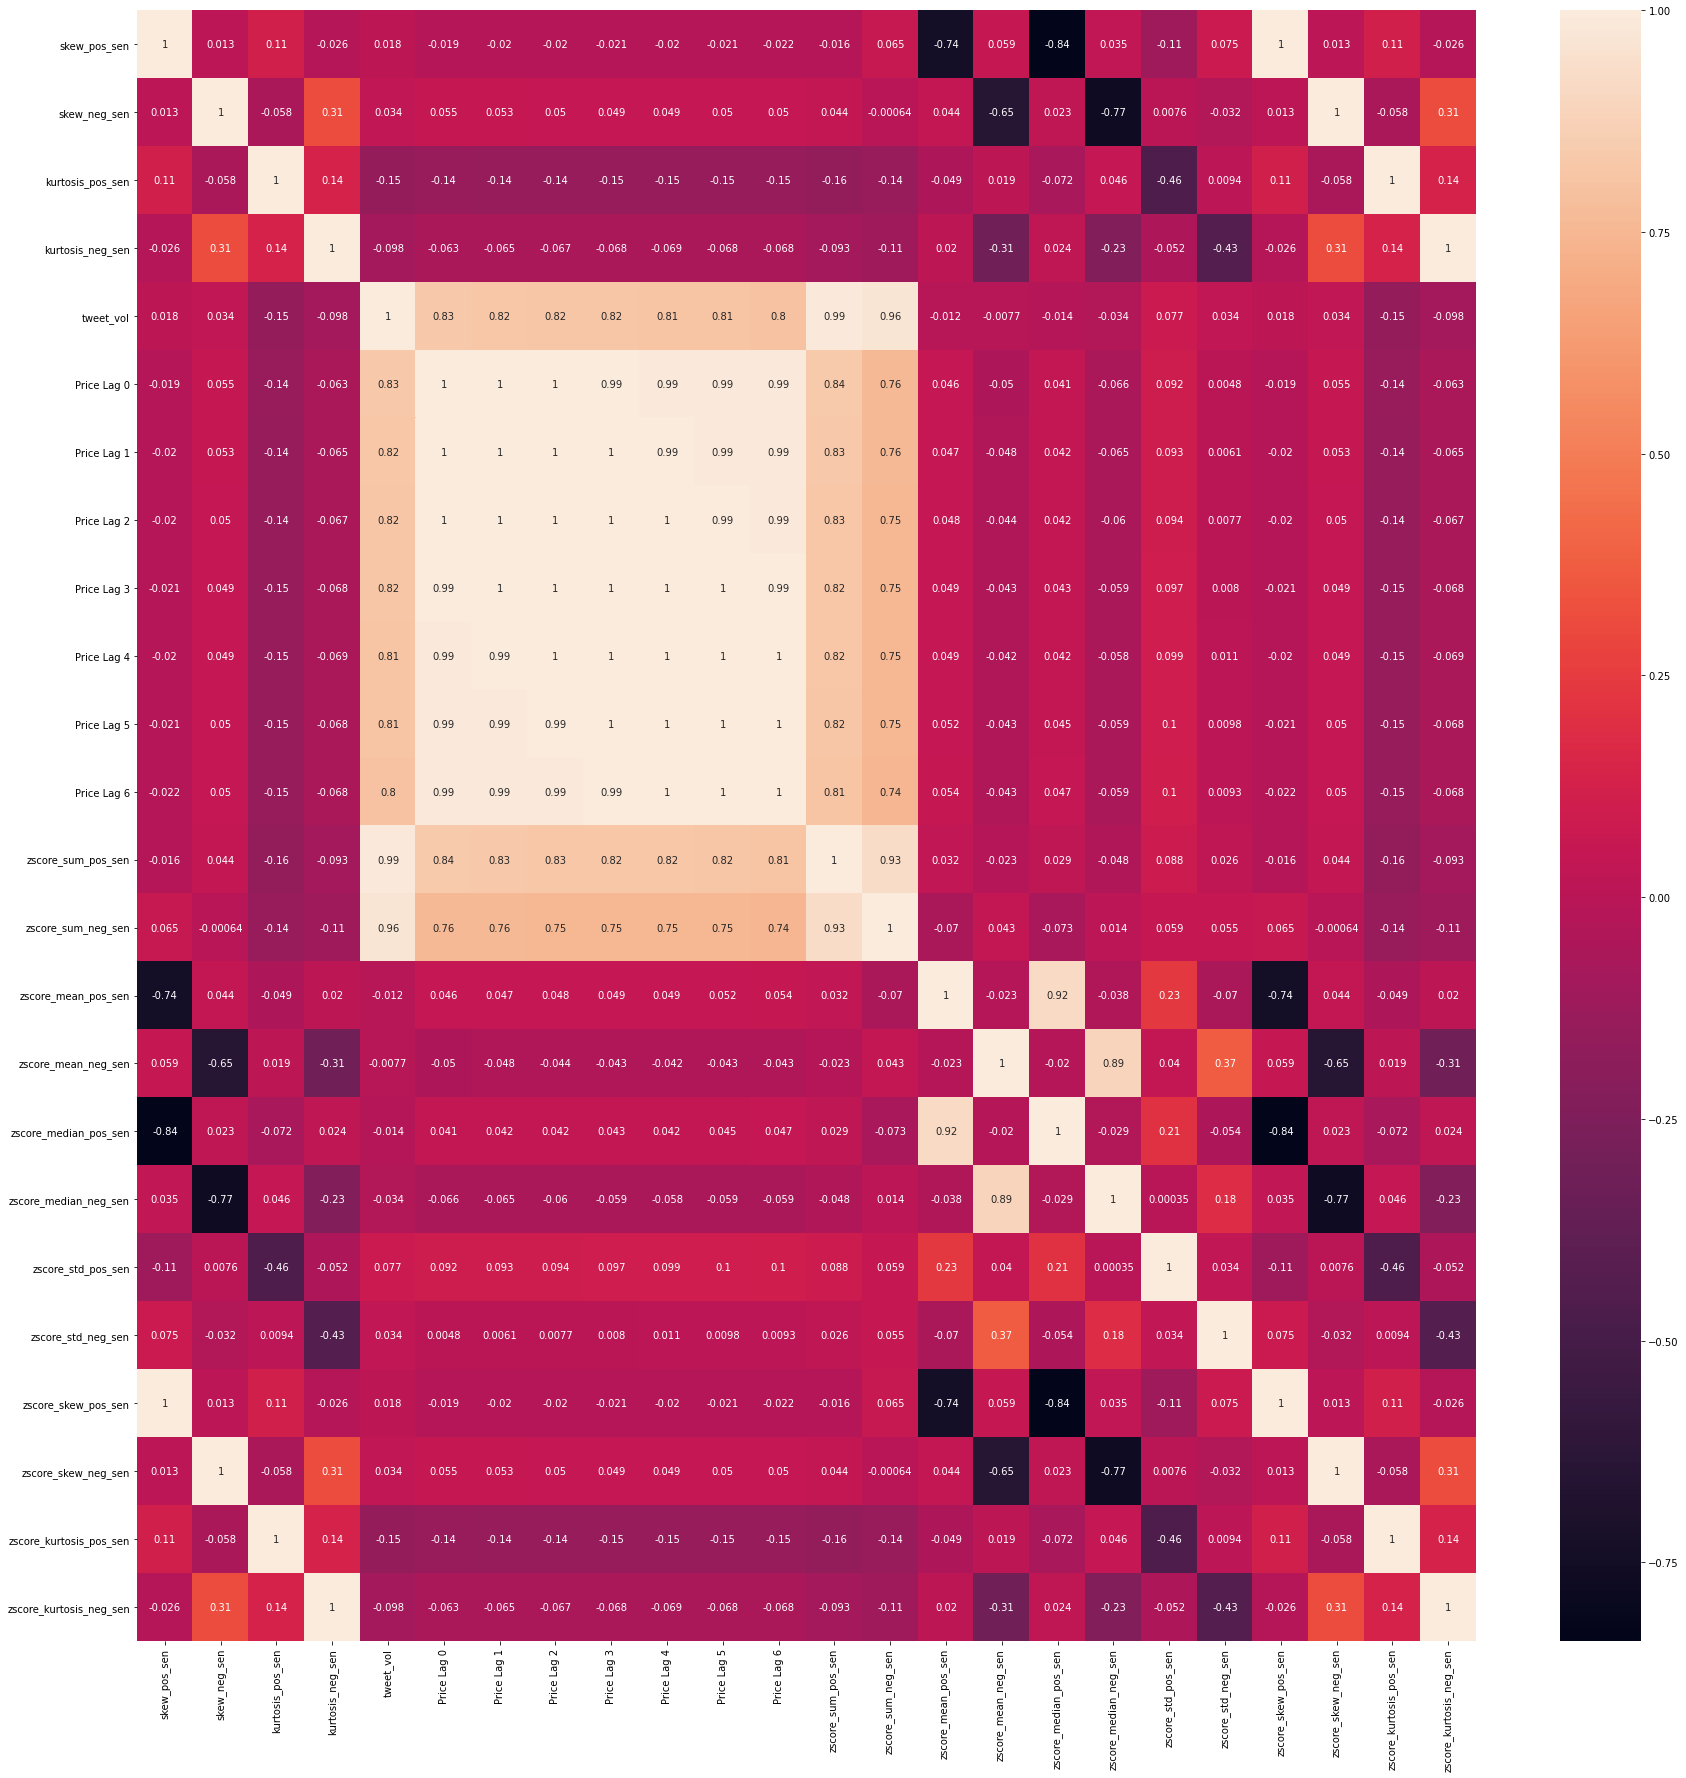

In [52]:
df = pd.read_csv(final_df_path)

df_dropped = df.drop("date", axis=1)

import seaborn as sns
import matplotlib.pyplot as plt

dims = (30, 30)
fig, ax = plt.subplots(figsize=dims)
sns.heatmap(df_dropped.drop([
                             "mean_pos_sen", "mean_neg_sen", "median_pos_sen", "median_neg_sen", "sum_pos_sen",
                             "sum_neg_sen", "std_pos_sen", "std_neg_sen", "pos_likes_count", "pos_retweets_count",
                             "neg_likes_count", "neg_retweets_count"
], axis=1).corr(), annot=True, ax=ax)